In [200]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import json
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus

### Wikipedia

In [2]:
urls = ['https://en.wikipedia.org/wiki/List_of_fiction_works_made_into_feature_films_(0%E2%80%939_and_A%E2%80%93C)',
       'https://en.wikipedia.org/wiki/List_of_fiction_works_made_into_feature_films_(D%E2%80%93J)',
       'https://en.wikipedia.org/wiki/List_of_fiction_works_made_into_feature_films_(K%E2%80%93R)',
       'https://en.wikipedia.org/wiki/List_of_fiction_works_made_into_feature_films_(S%E2%80%93Z)']

Scrape Wikipedia for works of fiction that have been turned into feature films

In [63]:
def return_dataframe(url):
    '''Takes in a url from the wikipedia "List of Fiction Works Made into 
    Feature Films", scrapes the page and returns a dataframe.
    '''
    response = requests.get(url)
    responsePage = response.text
    soup = BeautifulSoup(responsePage,'html.parser')
    
    bookMovie = []
    for tr in soup.find_all('tr')[2:]:
        if tr == 'NoneType':
            next
        else:
            cols = tr.find_all('td')
            x = []
            for td in cols:
                x.append(td.text)
            bookMovie.append(x)
    
    df = pd.DataFrame(bookMovie,columns=['fiction_work','film_adaptation'])
    return df

In [64]:
wikiDF = pd.DataFrame()

In [65]:
for url in urls:
    df = return_dataframe(url)
    print(df.head(2))
    wikiDF = wikiDF.append(df,ignore_index=True)

                                fiction_work       film_adaptation
0          100 Rifles (1958), Robert MacLeod     100 Rifles (1969)
1  101 Reykjavík (1996), Hallgrímur Helgason  101 Reykjavík (2000)
                          fiction_work           film_adaptation
0  The Da Vinci Code (2003), Dan Brown  The Da Vinci Code (2006)
1          Dad (1981), William Wharton                Dad (1989)
  fiction_work                                    film_adaptation
0         \n\n  This article does not cite any sources. Please...
1         None                                               None
                                     fiction_work  \
0  The Saga of Pecos Bill (1923), Edward O'Reilly   
1                    Sahara (1992), Clive Cussler   

                        film_adaptation  
0  Melody Time (1948)\nTall Tale (1995)  
1                         Sahara (2005)  


In [66]:
wikiDF.head()

,fiction_work,film_adaptation
0,"100 Rifles (1958), Robert MacLeod",100 Rifles (1969)
1,"101 Reykjavík (1996), Hallgrímur Helgason",101 Reykjavík (2000)
2,The 120 Days of Sodom (Les 120 journées de Sod...,Salò (1975)
3,"The 25th Hour (2001), David Benioff",25th Hour (2002)
4,"2010: Odyssey Two (1982), Arthur C. Clarke",2010 (1984)


In [67]:
wikiDF.shape

(1665, 2)

In [68]:
nullWiki = wikiDF[wikiDF.film_adaptation.isnull()]

In [69]:
nullWiki.shape

(24, 2)

In [70]:
nullWiki.head()

,fiction_work,film_adaptation
14,None,None
139,None,None
307,None,None
315,Bicho de Sete Cabeças (The Great Brain Storm) ...,None
541,None,None


Drop the columns with None as the value

In [71]:
wikiDF.dropna(subset=["film_adaptation"],axis=0,inplace=True)

In [72]:
wikiDF.shape

(1641, 2)

In [73]:
#wikiDF[['film_adaptation','film_year']] = wikiDF['film_adaptation'].str.split('(',expand=True)
#df[['V','allele']] = df['V'].str.split('-',expand=True)

In [74]:
# def find_year(name_year):
#     return re.findall('\s.(\d{4})',name_year)

In [75]:
# wikiDF['film_year'] = wikiDF['film_adaptation'].apply(lambda x: find_year(x))

In [76]:
# wikiDF.head(10)

In [77]:
# Split multiple books into separate rows
fiction_series = wikiDF['fiction_work'].str.split('\n').apply(pd.Series,1).stack()
fiction_series.index = fiction_series.index.droplevel(-1)
fiction_series.name = 'fiction_work'

In [78]:
fiction_series.shape

(1741,)

In [80]:
# Split multiple movies into separate rows
film_series = wikiDF['film_adaptation'].str.split('\n').apply(pd.Series,1).stack()
film_series.index = film_series.index.droplevel(-1)
film_series.name = 'film_adaptation'

In [81]:
film_series.shape

(3265,)

In [82]:
wikiDF.drop(['film_adaptation','fiction_work'],axis=1,inplace=True)

In [83]:
film_series[film_series.str.contains('Harry Potter')]
#wikiDF[wikiDF['fiction_work'].str.contains('Harry Potter')]

764                    Harry Potter (2001–2011) (series)
764      Harry Potter and the Philosopher's Stone (2001)
764     * Harry Potter and the Chamber of Secrets (2002)
764    ** Harry Potter and the Prisoner of Azkaban (2...
764      ** * Harry Potter and the Goblet of Fire (2005)
764    ** ** Harry Potter and the Order of the Phoeni...
764    ** ** * Harry Potter and the Half-Blood Prince...
764    ** ** ** Harry Potter and the Deathly Hallows ...
764    ** ** ** Harry Potter and the Deathly Hallows ...
Name: film_adaptation, dtype: object

In [84]:
fiction_series[fiction_series.str.contains('Harry Potter')]
#wikiDF[wikiDF['fiction_work'].str.contains('Harry Potter')]

764     Harry Potter (1997–2007) (series), J. K. Rowling
764      Harry Potter and the Philosopher's Stone (1997)
764     * Harry Potter and the Chamber of Secrets (1998)
764    ** Harry Potter and the Prisoner of Azkaban (1...
764      ** * Harry Potter and the Goblet of Fire (2000)
764    ** ** Harry Potter and the Order of the Phoeni...
764    ** ** * Harry Potter and the Half-Blood Prince...
764    ** ** ** Harry Potter and the Deathly Hallows ...
Name: fiction_work, dtype: object

convert both series to dataframes, create a key of index + name and then join them back together

In [85]:
filmDF = pd.DataFrame(film_series)

In [86]:
fictionDF = pd.DataFrame(fiction_series)

In [87]:
filmDF.head()

,film_adaptation
0,100 Rifles (1969)
1,101 Reykjavík (2000)
2,Salò (1975)
3,25th Hour (2002)
4,2010 (1984)


In [144]:
filmDF['key'] = str(filmDF.index.get_level_values(0).values)

In [145]:
filmDF['key'] = filmDF.apply(lambda x: x.index.get_level_values(0).values)

In [146]:
#filmDF['key'] = str(filmDF['key']) + '_' + filmDF['film_adaptation']

In [149]:
filmDF.key.astype('str',inplace=True)

0          0
1          1
2          2
3          3
4          4
5          5
5          5
6          6
7          7
8          8
9          9
10        10
11        11
11        11
12        12
13        13
15        15
15        15
16        16
17        17
18        18
19        19
20        20
21        21
22        22
23        23
24        24
25        25
26        26
27        27
        ... 
1637    1637
1638    1638
1639    1639
1639    1639
1639    1639
1639    1639
1639    1639
1640    1640
1642    1642
1643    1643
1644    1644
1645    1645
1646    1646
1647    1647
1648    1648
1649    1649
1650    1650
1651    1651
1652    1652
1653    1653
1654    1654
1655    1655
1657    1657
1658    1658
1659    1659
1660    1660
1661    1661
1662    1662
1663    1663
1664    1664
Name: key, Length: 3265, dtype: object

In [155]:
filmDF['film_adaptation'] = filmDF.film_adaptation.apply(lambda x: x.strip())

In [156]:
filmDF.head()

,film_adaptation,key
0,100 Rifles (1969),0
1,101 Reykjavík (2000),1
2,Salò (1975),2
3,25th Hour (2002),3
4,2010 (1984),4


In [159]:
filmDF['key'] = str(filmDF['key'])+ '_' + filmDF['film_adaptation']

In [160]:
filmDF

,film_adaptation,key
0,100 Rifles (1969),0 0\n1 1\n2 2\n3 ...
1,101 Reykjavík (2000),0 0\n1 1\n2 2\n3 ...
2,Salò (1975),0 0\n1 1\n2 2\n3 ...
3,25th Hour (2002),0 0\n1 1\n2 2\n3 ...
4,2010 (1984),0 0\n1 1\n2 2\n3 ...
5,"Murder, She Said (1961)",0 0\n1 1\n2 2\n3 ...
5,Le crime est notre affaire (2008),0 0\n1 1\n2 2\n3 ...
6,42nd Street (1933),0 0\n1 1\n2 2\n3 ...
7,48 Shades (2006),0 0\n1 1\n2 2\n3 ...
8,491 (1964),0 0\n1 1\n2 2\n3 ...


In [138]:
#filmDF[filmDF['film_adaptation'].str.contains('Harry Potter')]

In [57]:
# join the datasets back together
# 
#wikiDF = wikiDF.join(film_series,how='right')

In [58]:
#wikiDF[wikiDF['film_adaptation'].str.contains('Harry Potter')]
#df[df['ids'].str.contains("ball")]

In [59]:
#wikiDF = wikiDF.join(fiction_series, how='left')

In [60]:
wikiDF.shape

(1641, 1)

In [98]:
wikiDF.film_year = wikiDF.film_year.apply(lambda x: np.nan if len(x)==0 else x)

In [102]:
wikiDF.film_year.isnull().sum()

10

In [106]:
wikiDF.dropna(subset=['film_year'],axis=0,inplace=True)

In [107]:
wikiDF.shape

(4889, 3)

## IMDB

In [202]:
#origDF = pd.read_json('data/screenplay.json')
#movieDF = pd.read_json('data/movie_novels.json')
bookDF = pd.read_json('data/wikibooks.json')

In [203]:
movieDF.shape

(1990, 37)

In [204]:
bookDF.shape

(1209, 6)

In [6]:
origDF.shape

(76, 11)

In [7]:
# remove min from runtime and convert to int
movieDF['runtime'] = movieDF.runtime.str.replace(' min','')
movieDF.head()

,box_office,budget,director,genre,name,rating,release_date,runtime,url,user_rating,year
0,None,None,None,[ Drama],Call the Midwife,TV-PG,2012 (UK),60,http://www.imdb.com/title/tt1983079/?ref_=kw_l...,8.4,NaN
1,"$217,536,138","$125,000,000",Ron Howard,"[ Mystery, Thriller]",The Da Vinci Code,PG-13,19 May 2006 (USA),149,http://www.imdb.com/title/tt0382625/?ref_=kw_l...,6.6,2006.0
2,"$13,060,843","$5,000,000",Spike Lee,[ Drama],25th Hour,R,10 January 2003 (USA),135,http://www.imdb.com/title/tt0307901/?ref_=kw_l...,7.7,2002.0
3,"$9,170,214","$11,000,000",Lasse Hallström,[ Drama],What's Eating Gilbert Grape,PG-13,4 March 1994 (USA),118,http://www.imdb.com/title/tt0108550/?ref_=kw_l...,7.8,1993.0
4,"$81,001,787","$29,000,000",Nick Cassavetes,"[ Drama, Romance]",The Notebook,PG-13,25 June 2004 (USA),123,http://www.imdb.com/title/tt0332280/?ref_=kw_l...,7.9,2004.0


get_dummies for genre

In [8]:
movieDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 11 columns):
box_office      2047 non-null object
budget          2538 non-null object
director        8873 non-null object
genre           10000 non-null object
name            10000 non-null object
rating          5657 non-null object
release_date    9612 non-null object
runtime         8371 non-null object
url             10000 non-null object
user_rating     9666 non-null float64
year            8870 non-null float64
dtypes: float64(2), object(9)
memory usage: 937.5+ KB


In [9]:
movieDF.box_office.isnull().sum()

7953

In [10]:
movieDF.dropna(subset=['box_office'],axis=0,inplace=True)

In [11]:
movieDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2047 entries, 1 to 9939
Data columns (total 11 columns):
box_office      2047 non-null object
budget          1275 non-null object
director        2047 non-null object
genre           2047 non-null object
name            2047 non-null object
rating          1953 non-null object
release_date    2047 non-null object
runtime         1905 non-null object
url             2047 non-null object
user_rating     2047 non-null float64
year            2047 non-null float64
dtypes: float64(2), object(9)
memory usage: 191.9+ KB


In [12]:
# replace the dollar signs in currency fields
# box office
movieDF['box_office'] = movieDF['box_office'].str.replace('$','')
movieDF['box_office'] = movieDF['box_office'].str.replace(',','')
movieDF['box_office'] = movieDF['box_office'].astype(int)
# budget
movieDF['budget'] = movieDF['budget'].str.replace('$','')
movieDF['budget'] = movieDF['budget'].str.replace(',','')
movieDF.budget.fillna(value=1, inplace=True)
#movieDF['budget'] = movieDF['budget'].astype(int)

In [13]:
movieDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2047 entries, 1 to 9939
Data columns (total 11 columns):
box_office      2047 non-null int64
budget          2047 non-null object
director        2047 non-null object
genre           2047 non-null object
name            2047 non-null object
rating          1953 non-null object
release_date    2047 non-null object
runtime         1905 non-null object
url             2047 non-null object
user_rating     2047 non-null float64
year            2047 non-null float64
dtypes: float64(2), int64(1), object(8)
memory usage: 191.9+ KB


### Need to fix unicode characters in Currency

In [14]:
#type(origDF.budget)

In [15]:
def convert_currency(row):
    if type(row) == str:
        if '£' in row:
            row = row.replace('£','',1)
            row = row.replace(',','')
            print(row)
            row = float(row)
            return row * 1.34
        if '€' in row:
            row = row.replace('€','',1)
            row = row.replace(',','')
            print(row)
            row = float(row)
            return row * .85
        else:
            return row
    else:
        return row
        

In [16]:
origDF['budget'] = origDF['budget'].apply(convert_currency)

67000
400000
2300000


In [17]:
origDF[origDF['name'].str.contains('The Crying Game')]

,box_office,budget,director,genre,name,rating,release_date,runtime,url,user_rating,year
53,"$62,549,000",3.082e+06,Neil Jordan,"[ Crime, Drama, Romance, Thriller]",The Crying Game,R,19 February 1993 (USA),112 min,http://www.imdb.com/title/tt0104036/,7.3,1992


In [18]:
#origDF['budget'] = origDF.budget.astype(int)

In [19]:
# Fill Null values with 0 and covnert to int
movieDF['runtime'] = movieDF.runtime.fillna(value=0)

In [20]:
movieDF['runtime'] = movieDF.runtime.astype('int')

In [21]:
movieDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2047 entries, 1 to 9939
Data columns (total 11 columns):
box_office      2047 non-null int64
budget          2047 non-null object
director        2047 non-null object
genre           2047 non-null object
name            2047 non-null object
rating          1953 non-null object
release_date    2047 non-null object
runtime         2047 non-null int64
url             2047 non-null object
user_rating     2047 non-null float64
year            2047 non-null float64
dtypes: float64(2), int64(2), object(7)
memory usage: 191.9+ KB


In [22]:
movieDF.head()

,box_office,budget,director,genre,name,rating,release_date,runtime,url,user_rating,year
1,217536138,125000000,Ron Howard,"[ Mystery, Thriller]",The Da Vinci Code,PG-13,19 May 2006 (USA),149,http://www.imdb.com/title/tt0382625/?ref_=kw_l...,6.6,2006.0
2,13060843,5000000,Spike Lee,[ Drama],25th Hour,R,10 January 2003 (USA),135,http://www.imdb.com/title/tt0307901/?ref_=kw_l...,7.7,2002.0
3,9170214,11000000,Lasse Hallström,[ Drama],What's Eating Gilbert Grape,PG-13,4 March 1994 (USA),118,http://www.imdb.com/title/tt0108550/?ref_=kw_l...,7.8,1993.0
4,81001787,29000000,Nick Cassavetes,"[ Drama, Romance]",The Notebook,PG-13,25 June 2004 (USA),123,http://www.imdb.com/title/tt0332280/?ref_=kw_l...,7.9,2004.0
5,26384681,100000000,Timur Bekmambetov,"[ Action, Adventure, Drama, History]",Ben-Hur,PG-13,19 August 2016 (USA),123,http://www.imdb.com/title/tt2638144/?ref_=kw_l...,5.7,2016.0


In [23]:
dateDF = movieDF.release_date.str.split(expand=True)

In [24]:
movieDF.drop('year',axis=1,inplace=True)

In [25]:
dateDF.head()

,0,1,2,3,4,5
1,19,May,2006,(USA),None,None
2,10,January,2003,(USA),None,None
3,4,March,1994,(USA),None,None
4,25,June,2004,(USA),None,None
5,19,August,2016,(USA),None,None


In [26]:
dateDF.columns = ['day','month','year','country','x1', 'x2']

In [27]:
dateDF.to_csv('dates.csv')

In [28]:
dateDF.drop(['x1','x2'],inplace=True,axis=1)

In [29]:
dropdates = [320,424,750,789,982,1067,1128,1232,1353,1364,1614,1695,1734,1739,1782,
             1914,2031,2120,2145,2600,2755,2792,2905,3147,3215,3223,3476,3808,3813,3876,
             3916,4012,4106,4469,4581,4819,4882,5027,5038,5333,5542,5609,5639,5666,5877,
             5978,6061,6077,6539,6552,6618,7520,8381,8513,8847,9046]

In [30]:
movieDF = movieDF.join(dateDF)

In [31]:
movieDF.drop(dropdates, axis=0,inplace=True)

In [32]:
#dateDF['monthnum'] = dateDf['month'].replace([])

In [33]:
movieDF.shape

(1991, 14)

In [34]:
movieDF.columns.tolist()

['box_office',
 'budget',
 'director',
 'genre',
 'name',
 'rating',
 'release_date',
 'runtime',
 'url',
 'user_rating',
 'day',
 'month',
 'year',
 'country']

In [35]:
movieDF.year.unique()

array(['2006', '2003', '1994', '2004', '2016', '1987', '2011', '2002',
       '2015', '2009', '1993', '2010', '1977', '2017', '1984', '2001',
       '2014', '1953', '1997', '2000', '1995', '1971', '2007', '2008',
       '2012', '1990', '1961', '1983', '1989', '1986', '1992', '1957',
       '1985', '1956', '2005', '1999', '1980', '1988', '1931', '1965',
       '1979', '1933', '1940', '2013', '1998', '1969', '1996', '1974',
       '1981', '1978', '1964', '1991', '1963', '1967', '1972', '1976',
       '1962', '1960', '1982', '1973', '1958', '1947', '1968', '1975',
       '1966', '1970', '1942', '1944', '1949', '1955', '1954', '1915',
       '1943', '1946', '1926', '1928', '1945', '1959', '1934', '1930',
       '1948', '1951', '1939', '1952', '1941', '1937', '1918', '1921',
       '1936', '1925', '1916', '1922', '1923', '1929', '1927', '1919',
       '(USA)', '1924'], dtype=object)

In [36]:
movieDF.day.unique()

array(['19', '10', '4', '25', '9', '21', '1', '18', '8', '2', '16', '15',
       '24', '7', '6', '3', '26', '14', '23', '28', '31', '5', '13', '30',
       '22', '17', '27', '11', '29', '20', '12', 'October'], dtype=object)

In [37]:
movieDF.month.unique()

array(['May', 'January', 'March', 'June', 'August', 'October', 'July',
       'December', 'September', 'February', 'April', 'November', '1991'], dtype=object)

In [38]:
movieDF.loc[movieDF['month'] == '1991']

,box_office,budget,director,genre,name,rating,release_date,runtime,url,user_rating,day,month,year,country
9150,342198,1,Claude Berri,"[ Comedy, Drama]",Uranus,R,October 1991 (USA),0,http://www.imdb.com/title/tt0100851/?ref_=kw_l...,7.2,October,1991,(USA),None


In [39]:
movieDF.drop(9150, axis=0,inplace=True)

In [40]:
monthDict = {'January':1, 'February':2, 'March':3, 'April': 4, 'May': 5, 'June':6, 'July':7,
            'August':8, 'September':9, 'October':10, 'November':11, 'December':12}

In [41]:
movieDF['monthnums'] = movieDF.month.map(monthDict)

In [42]:
movieDF.head()

,box_office,budget,director,genre,name,rating,release_date,runtime,url,user_rating,day,month,year,country,monthnums
1,217536138,125000000,Ron Howard,"[ Mystery, Thriller]",The Da Vinci Code,PG-13,19 May 2006 (USA),149,http://www.imdb.com/title/tt0382625/?ref_=kw_l...,6.6,19,May,2006,(USA),5
2,13060843,5000000,Spike Lee,[ Drama],25th Hour,R,10 January 2003 (USA),135,http://www.imdb.com/title/tt0307901/?ref_=kw_l...,7.7,10,January,2003,(USA),1
3,9170214,11000000,Lasse Hallström,[ Drama],What's Eating Gilbert Grape,PG-13,4 March 1994 (USA),118,http://www.imdb.com/title/tt0108550/?ref_=kw_l...,7.8,4,March,1994,(USA),3
4,81001787,29000000,Nick Cassavetes,"[ Drama, Romance]",The Notebook,PG-13,25 June 2004 (USA),123,http://www.imdb.com/title/tt0332280/?ref_=kw_l...,7.9,25,June,2004,(USA),6
5,26384681,100000000,Timur Bekmambetov,"[ Action, Adventure, Drama, History]",Ben-Hur,PG-13,19 August 2016 (USA),123,http://www.imdb.com/title/tt2638144/?ref_=kw_l...,5.7,19,August,2016,(USA),8


In [43]:
movieDF['release_date'] = movieDF['monthnums'].map(str)+"/"+movieDF['day'].map(str)+'/'+movieDF['year'].map(str)

In [44]:
movieDF['release_date'] = pd.to_datetime(movieDF.release_date)

In [45]:
#Cleanup Genres and convert to indicator variables
movieDF['genre'] = movieDF.genre.apply(lambda x: ','.join(x))
movieDF['genre'] = movieDF.genre.str.strip()

In [46]:
movieDF.head()

,box_office,budget,director,genre,name,rating,release_date,runtime,url,user_rating,day,month,year,country,monthnums
1,217536138,125000000,Ron Howard,"Mystery, Thriller",The Da Vinci Code,PG-13,2006-05-19,149,http://www.imdb.com/title/tt0382625/?ref_=kw_l...,6.6,19,May,2006,(USA),5
2,13060843,5000000,Spike Lee,Drama,25th Hour,R,2003-01-10,135,http://www.imdb.com/title/tt0307901/?ref_=kw_l...,7.7,10,January,2003,(USA),1
3,9170214,11000000,Lasse Hallström,Drama,What's Eating Gilbert Grape,PG-13,1994-03-04,118,http://www.imdb.com/title/tt0108550/?ref_=kw_l...,7.8,4,March,1994,(USA),3
4,81001787,29000000,Nick Cassavetes,"Drama, Romance",The Notebook,PG-13,2004-06-25,123,http://www.imdb.com/title/tt0332280/?ref_=kw_l...,7.9,25,June,2004,(USA),6
5,26384681,100000000,Timur Bekmambetov,"Action, Adventure, Drama, History",Ben-Hur,PG-13,2016-08-19,123,http://www.imdb.com/title/tt2638144/?ref_=kw_l...,5.7,19,August,2016,(USA),8


In [47]:
genreDF = movieDF.genre.str.get_dummies(sep = ", ")

In [48]:
genreDF.columns.tolist()

['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Thriller',
 'War',
 'Western']

Check to see if there are any null values in the data set.

In [49]:
movieDF = movieDF.join(genreDF)

In [50]:
movieDF.head()

,box_office,budget,director,genre,name,rating,release_date,runtime,url,user_rating,...,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
1,217536138,125000000,Ron Howard,"Mystery, Thriller",The Da Vinci Code,PG-13,2006-05-19,149,http://www.imdb.com/title/tt0382625/?ref_=kw_l...,6.6,...,0,0,1,0,0,0,0,1,0,0
2,13060843,5000000,Spike Lee,Drama,25th Hour,R,2003-01-10,135,http://www.imdb.com/title/tt0307901/?ref_=kw_l...,7.7,...,0,0,0,0,0,0,0,0,0,0
3,9170214,11000000,Lasse Hallström,Drama,What's Eating Gilbert Grape,PG-13,1994-03-04,118,http://www.imdb.com/title/tt0108550/?ref_=kw_l...,7.8,...,0,0,0,0,0,0,0,0,0,0
4,81001787,29000000,Nick Cassavetes,"Drama, Romance",The Notebook,PG-13,2004-06-25,123,http://www.imdb.com/title/tt0332280/?ref_=kw_l...,7.9,...,0,0,0,1,0,0,0,0,0,0
5,26384681,100000000,Timur Bekmambetov,"Action, Adventure, Drama, History",Ben-Hur,PG-13,2016-08-19,123,http://www.imdb.com/title/tt2638144/?ref_=kw_l...,5.7,...,0,0,0,0,0,0,0,0,0,0


In [51]:
movieDF.drop('genre',axis=1,inplace=True)

In [62]:
movieDF

,box_office,budget,director,name,rating,release_date,runtime,url,user_rating,day,...,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
1,217536138,125000000,Ron Howard,The Da Vinci Code,PG-13,2006-05-19,149,http://www.imdb.com/title/tt0382625/?ref_=kw_l...,6.6,19,...,0,0,1,0,0,0,0,1,0,0
2,13060843,5000000,Spike Lee,25th Hour,R,2003-01-10,135,http://www.imdb.com/title/tt0307901/?ref_=kw_l...,7.7,10,...,0,0,0,0,0,0,0,0,0,0
3,9170214,11000000,Lasse Hallström,What's Eating Gilbert Grape,PG-13,1994-03-04,118,http://www.imdb.com/title/tt0108550/?ref_=kw_l...,7.8,4,...,0,0,0,0,0,0,0,0,0,0
4,81001787,29000000,Nick Cassavetes,The Notebook,PG-13,2004-06-25,123,http://www.imdb.com/title/tt0332280/?ref_=kw_l...,7.9,25,...,0,0,0,1,0,0,0,0,0,0
5,26384681,100000000,Timur Bekmambetov,Ben-Hur,PG-13,2016-08-19,123,http://www.imdb.com/title/tt2638144/?ref_=kw_l...,5.7,19,...,0,0,0,0,0,0,0,0,0,0
6,30857814,16000000,Rob Reiner,The Princess Bride,PG,1987-10-09,98,http://www.imdb.com/title/tt0093779/?ref_=kw_l...,8.1,9,...,0,0,0,1,0,0,0,0,0,0
7,1738692,7000000,Lynne Ramsay,We Need to Talk About Kevin,R,2011-10-21,112,http://www.imdb.com/title/tt1242460/?ref_=kw_l...,7.5,21,...,0,0,1,0,0,0,0,1,0,0
8,93149898,78000000,Brett Ratner,Red Dragon,R,2002-10-04,124,http://www.imdb.com/title/tt0289765/?ref_=kw_l...,7.2,4,...,0,0,0,0,0,0,0,1,0,0
9,6743776,8000000,Alfonso Gomez-Rejon,Me and Earl and the Dying Girl,PG-13,2015-07-01,105,http://www.imdb.com/title/tt2582496/?ref_=kw_l...,7.8,1,...,0,0,0,0,0,0,0,0,0,0
10,56692,25000000,John Hillcoat,The Road,R,2009-12-18,111,http://www.imdb.com/title/tt0898367/?ref_=kw_l...,7.3,18,...,0,0,0,0,0,0,0,0,0,0


In [63]:
movieDF.corr()

,box_office,runtime,user_rating,monthnums,Action,Adventure,Animation,Biography,Comedy,Crime,...,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
box_office,1.000000,0.197268,0.158889,0.050865,0.123172,0.332381,0.093808,-0.029724,-0.002119,-0.043438,...,-0.033551,0.027153,0.080745,-0.083873,0.134222,-0.002103,-0.006727,0.056365,-0.030151,0.013710
runtime,0.197268,1.000000,0.281052,0.078845,0.048157,0.037752,-0.088030,0.089757,-0.156933,0.026179,...,-0.004230,-0.014647,0.039425,-0.014590,0.004046,-0.046172,-0.018103,0.023695,0.136663,0.040027
user_rating,0.158889,0.281052,1.000000,0.065972,-0.147867,-0.050667,0.049943,0.099115,-0.136325,0.018445,...,0.015568,-0.009843,0.002575,0.003983,-0.094850,0.033880,0.012010,-0.105706,0.117165,0.042862
monthnums,0.050865,0.078845,0.065972,1.000000,-0.029854,0.026978,-0.020695,-0.005879,-0.006768,0.006264,...,0.000979,0.014921,-0.022398,-0.007400,-0.010967,0.032542,-0.014835,-0.025125,0.019082,0.050232
Action,0.123172,0.048157,-0.147867,-0.029854,1.000000,0.281619,-0.030501,-0.045535,-0.106668,0.116053,...,-0.048969,-0.050442,0.010676,-0.139940,0.214774,-0.008499,-0.015529,0.298456,0.019983,-0.002915
Adventure,0.332381,0.037752,-0.050667,0.026978,0.281619,1.000000,0.229145,-0.047140,-0.009734,-0.138653,...,-0.043756,0.092524,-0.043009,-0.119208,0.171901,-0.010124,-0.050929,-0.041790,-0.002807,0.073522
Animation,0.093808,-0.088030,0.049943,-0.020695,-0.030501,0.229145,1.000000,-0.032627,0.068666,-0.048393,...,-0.007676,0.316337,-0.004199,-0.086819,0.074097,0.128277,-0.019716,-0.069068,-0.046779,-0.005055
Biography,-0.029724,0.089757,0.099115,-0.005879,-0.045535,-0.047140,-0.032627,1.000000,-0.054101,-0.026173,...,0.044353,0.006296,-0.071076,0.011128,-0.053102,-0.004185,0.079000,-0.091234,0.016980,0.030739
Comedy,-0.002119,-0.156933,-0.136325,-0.006768,-0.106668,-0.009734,0.068666,-0.054101,1.000000,-0.061720,...,0.050631,0.053869,-0.136856,0.047352,-0.075911,0.041539,0.036260,-0.255271,-0.081877,-0.029076
Crime,-0.043438,0.026179,0.018445,0.006264,0.116053,-0.138653,-0.048393,-0.026173,-0.061720,1.000000,...,-0.018408,-0.072508,0.242301,-0.161013,-0.099496,-0.010233,-0.027583,0.404490,-0.100819,-0.048496


## MVP

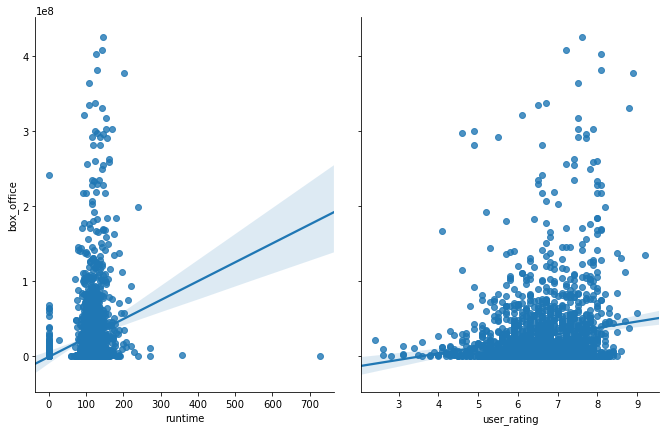

In [64]:
sns.pairplot(movieDF, x_vars=['runtime', 'user_rating'], y_vars='box_office', size=6, aspect=0.8, kind='reg')

In [65]:
movieDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 1 to 9939
Data columns (total 37 columns):
box_office      1990 non-null int64
budget          1990 non-null object
director        1990 non-null object
name            1990 non-null object
rating          1899 non-null object
release_date    1990 non-null datetime64[ns]
runtime         1990 non-null int64
url             1990 non-null object
user_rating     1990 non-null float64
day             1990 non-null object
month           1990 non-null object
year            1990 non-null object
country         1990 non-null object
monthnums       1990 non-null int64
Action          1990 non-null int64
Adventure       1990 non-null int64
Animation       1990 non-null int64
Biography       1990 non-null int64
Comedy          1990 non-null int64
Crime           1990 non-null int64
Documentary     1990 non-null int64
Drama           1990 non-null int64
Family          1990 non-null int64
Fantasy         1990 non-null int64
Film-Noir

In [66]:
y= movieDF['box_office']
X=movieDF.drop(['box_office','budget', 'director','name', 'rating', 'url', 'day','month','year','country','release_date'],1)

In [67]:
lr=LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.21406681135213557

In [1]:
# sns.jointplot('user_rating', 'box_office',movieDF, kind="reg")
# print("R^2:", stats.pearsonr(X.values.flatten(),y.values)[0]**2)

In [309]:
#movieDF[movieDF['budget'].str.contains('€')]
#movieDF.budget.value_counts()

In [160]:
lr = LinearRegression()

In [68]:
movieDF.budget.isnull().sum()

0

In [69]:
idx = movieDF.budget.str.contains('\D', 
             flags=re.IGNORECASE, regex=True, na=False)

In [71]:
nonUSDF = movieDF[idx]

In [74]:
nonUSDF.shape

(102, 37)

In [83]:
usMovieDF = movieDF[-usIDX]

In [84]:
usMovieDF.shape

(1888, 37)

In [85]:
usMovieDF.head()

,box_office,budget,director,name,rating,release_date,runtime,url,user_rating,day,...,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
1,217536138,125000000,Ron Howard,The Da Vinci Code,PG-13,2006-05-19,149,http://www.imdb.com/title/tt0382625/?ref_=kw_l...,6.6,19,...,0,0,1,0,0,0,0,1,0,0
2,13060843,5000000,Spike Lee,25th Hour,R,2003-01-10,135,http://www.imdb.com/title/tt0307901/?ref_=kw_l...,7.7,10,...,0,0,0,0,0,0,0,0,0,0
3,9170214,11000000,Lasse Hallström,What's Eating Gilbert Grape,PG-13,1994-03-04,118,http://www.imdb.com/title/tt0108550/?ref_=kw_l...,7.8,4,...,0,0,0,0,0,0,0,0,0,0
4,81001787,29000000,Nick Cassavetes,The Notebook,PG-13,2004-06-25,123,http://www.imdb.com/title/tt0332280/?ref_=kw_l...,7.9,25,...,0,0,0,1,0,0,0,0,0,0
5,26384681,100000000,Timur Bekmambetov,Ben-Hur,PG-13,2016-08-19,123,http://www.imdb.com/title/tt2638144/?ref_=kw_l...,5.7,19,...,0,0,0,0,0,0,0,0,0,0


In [93]:
usMovieDF['budget'] = usMovieDF.budget.astype('int')

/Users/xavier/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [94]:
usMovieDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1888 entries, 1 to 9939
Data columns (total 38 columns):
box_office      1888 non-null int64
budget          1888 non-null int64
director        1888 non-null object
name            1888 non-null object
rating          1808 non-null object
release_date    1888 non-null datetime64[ns]
runtime         1888 non-null int64
url             1888 non-null object
user_rating     1888 non-null float64
day             1888 non-null object
month           1888 non-null object
year            1888 non-null object
country         1888 non-null object
monthnums       1888 non-null int64
Action          1888 non-null int64
Adventure       1888 non-null int64
Animation       1888 non-null int64
Biography       1888 non-null int64
Comedy          1888 non-null int64
Crime           1888 non-null int64
Documentary     1888 non-null int64
Drama           1888 non-null int64
Family          1888 non-null int64
Fantasy         1888 non-null int64
Film-Noir 

In [96]:
movieDF['day'] = pd.to_datetime(movieDF['release_date'].dt.day)

In [97]:
movieDF['year'] = pd.to_datetime(movieDF['release_date'].dt.year)

In [99]:
movieDF['monthnums'] = pd.to_datetime(movieDF['release_date'].dt.month)

In [100]:
movieDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 1 to 9939
Data columns (total 37 columns):
box_office      1990 non-null int64
budget          1990 non-null object
director        1990 non-null object
name            1990 non-null object
rating          1899 non-null object
release_date    1990 non-null datetime64[ns]
runtime         1990 non-null int64
url             1990 non-null object
user_rating     1990 non-null float64
day             1990 non-null datetime64[ns]
month           1990 non-null object
year            1990 non-null datetime64[ns]
country         1990 non-null object
monthnums       1990 non-null datetime64[ns]
Action          1990 non-null int64
Adventure       1990 non-null int64
Animation       1990 non-null int64
Biography       1990 non-null int64
Comedy          1990 non-null int64
Crime           1990 non-null int64
Documentary     1990 non-null int64
Drama           1990 non-null int64
Family          1990 non-null int64
Fantasy         1990

In [177]:
bookDF.head()

,author,book_name,genre,isbn,publication_date,url
0,Marquis de Sade,The 120 Days of Sodom,"[Erotic fiction, philosophical literature]",(recent edition),1904,https://en.wikipedia.org/wiki/The_120_Days_of_...
1,Jack Bickham,The Apple Dumpling Gang,[],None,None,https://en.wikipedia.org/wiki/The_Apple_Dumpli...
2,Robert Ludlum,The Apocalypse Watch,[Thriller],None,"April 10, 1995",https://en.wikipedia.org/wiki/The_Apocalypse_W...
3,None,Antonieta,[],None,None,https://en.wikipedia.org/wiki/Antonieta
4,None,None,[],None,None,https://en.wikipedia.org/wiki/The_Antagonists


In [178]:
bookDF.shape

(1209, 6)

In [206]:
# drop where auther is null
bookDF.isnull().sum()

author               292
book_name            104
genre                  0
isbn                1089
publication_date     448
url                    0
dtype: int64

In [207]:
#since isbn seems to be useless I am going to drop the column
bookDF.drop('isbn',axis=1,inplace=True)

In [208]:
bookDF.dropna(subset=['author'],axis=0, inplace=True)

In [209]:
bookDF.shape

(917, 5)

In [210]:
# also if there are no book names then it is useless to me
bookDF.dropna(subset=['book_name'],axis=0, inplace=True)

In [211]:
bookDF.head()

,author,book_name,genre,publication_date,url
0,Marquis de Sade,The 120 Days of Sodom,"[Erotic fiction, philosophical literature]",1904,https://en.wikipedia.org/wiki/The_120_Days_of_...
1,Jack Bickham,The Apple Dumpling Gang,[],None,https://en.wikipedia.org/wiki/The_Apple_Dumpli...
2,Robert Ludlum,The Apocalypse Watch,[Thriller],"April 10, 1995",https://en.wikipedia.org/wiki/The_Apocalypse_W...
5,Lucy Maud Montgomery,Anne of Green Gables,[],None,https://en.wikipedia.org/wiki/Anne_of_Green_Ga...
6,Lucy Maud Montgomery,Anne of Avonlea,[Children's novel],1909,https://en.wikipedia.org/wiki/Anne_of_Avonlea


In [175]:
bookDF.head()

,author,book_name,genre,publication_date,url
0,Marquis de Sade,The 120 Days of Sodom,NaN,1904,https://en.wikipedia.org/wiki/The_120_Days_of_...
1,Jack Bickham,The Apple Dumpling Gang,NaN,None,https://en.wikipedia.org/wiki/The_Apple_Dumpli...
2,Robert Ludlum,The Apocalypse Watch,NaN,"April 10, 1995",https://en.wikipedia.org/wiki/The_Apocalypse_W...
5,Lucy Maud Montgomery,Anne of Green Gables,NaN,None,https://en.wikipedia.org/wiki/Anne_of_Green_Ga...
6,Lucy Maud Montgomery,Anne of Avonlea,NaN,1909,https://en.wikipedia.org/wiki/Anne_of_Avonlea


In [216]:
##Cleanup Genres and convert to indicator variables
bookDF['genre'] = bookDF.genre.apply(lambda x: ','.join(x))
bookDF['genre'] = bookDF.genre.str.strip()

In [222]:
genreList = ['horror', 'thriller','spy','science fiction', 'fantasy', 
                                  'distopia','novel','fiction','crime', 'young adult']
bookDF[bookDF['genre'].str.contains('horror')]
##filmDF[filmDF['film_adaptation'].str.contains('Harry Potter')]

,author,book_name,genre,publication_date,url
13,Stephen King,Cycle of the Werewolf,"Gothic,horror",November,https://en.wikipedia.org/wiki/Cycle_of_the_Wer...
39,Susan Hill,The Woman in Black,"Ghost story,horror novel",10 October 1983,https://en.wikipedia.org/wiki/The_Woman_in_Black
229,Thomas Harris,The Silence of the Lambs,"Horror,thriller,psychological horror",1988,https://en.wikipedia.org/wiki/The_Silence_of_t...
298,Thomas Harris,Red Dragon,"Crime,horror,thriller,psychological horror",October 1981,https://en.wikipedia.org/wiki/Red_Dragon_(novel)
449,Stephen King,Misery,Psychological horror,None,https://en.wikipedia.org/wiki/Misery_(novel)
518,John Ajvide Lindqvist,Let the Right One In,"Gothic,horror",None,https://en.wikipedia.org/wiki/Let_the_Right_On...
579,Anne Rice,Interview with the Vampire,"Gothic,horror,vampire",None,https://en.wikipedia.org/wiki/Interview_with_t...
592,Richard Matheson,I Am Legend,"Science fiction,horror,vampire fiction,post-ap...",None,https://en.wikipedia.org/wiki/I_Am_Legend_(novel)
624,Clive Barker,The Hellbound Heart,"Horror,Gothic horror",None,https://en.wikipedia.org/wiki/The_Hellbound_Heart
644,Thomas Harris,Hannibal,"Thriller,horror,gothic",8 June 1999,https://en.wikipedia.org/wiki/Hannibal_(Harris...


In [223]:
bookDF2 = pd.DataFrame()
for g in genreList:
    df = bookDF[bookDF['genre'].str.contains(g)]
    bookDF2 = bookDF2.append(df,ignore_index=True)
        

In [224]:
bookDF2.shape

(482, 5)

In [225]:
bookDF2.genre.value_counts()

Crime novel                                                                                      29
Science fiction                                                                                  26
Historical novel                                                                                 13
Spy fiction                                                                                      12
War novel                                                                                        10
Thriller novel                                                                                    9
Spy novel                                                                                         9
Horror novel                                                                                      8
Children's novel                                                                                  8
Adventure novel                                                                                   7


In [187]:
bookDF['genre'] = bookDF['genre'].str.lower()

In [188]:
bookDF.head()

,author,book_name,genre,publication_date,url
0,Marquis de Sade,The 120 Days of Sodom,"erotic fiction,philosophical literature",1904,https://en.wikipedia.org/wiki/The_120_Days_of_...
1,Jack Bickham,The Apple Dumpling Gang,,None,https://en.wikipedia.org/wiki/The_Apple_Dumpli...
2,Robert Ludlum,The Apocalypse Watch,thriller,"April 10, 1995",https://en.wikipedia.org/wiki/The_Apocalypse_W...
5,Lucy Maud Montgomery,Anne of Green Gables,,None,https://en.wikipedia.org/wiki/Anne_of_Green_Ga...
6,Lucy Maud Montgomery,Anne of Avonlea,children's novel,1909,https://en.wikipedia.org/wiki/Anne_of_Avonlea


In [189]:
bookGenreDF = bookDF.genre.str.get_dummies(sep = ",")

In [190]:
bookGenreDF.head()

,absurdist fiction,action,adventure,adventure fiction,adventure novel,allegorical,alternate history,alternate history novel,anti-nihilistic novel,arthurian legend,...,western,western (genre),western fiction,western novel,wuxia,young adult,young adult fiction,young adult literature,young adult novel,young-adult novel
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [193]:
bookGenreDF.columns.tolist()

['absurdist fiction',
 'action',
 'adventure',
 'adventure fiction',
 'adventure novel',
 'allegorical',
 'alternate history',
 'alternate history novel',
 'anti-nihilistic novel',
 'arthurian legend',
 'autobiographical',
 'autobiographical novel',
 'autobiography',
 'bangsian fantasy',
 'bildungsroman',
 'biographical',
 'biographical novel',
 'black comedy',
 'black humor',
 'chick lit',
 "children's",
 "children's book",
 "children's fiction",
 "children's literature",
 "children's novel",
 "children's picture book",
 'chivalric romance',
 'christian literature',
 'christian novel',
 'christian novels',
 'comedy',
 'comedy novel',
 'coming of age',
 'coming-of-age novel',
 'coming-of-age story',
 'conspiracy fiction',
 'conspiracy thriller',
 'crime',
 'crime fiction',
 'crime novel',
 'crime thriller',
 'dark comedy',
 'dark fantasy',
 'detective',
 'detective fiction',
 'detective novel',
 'disaster',
 'drama',
 'dystopia',
 'dystopian',
 'dystopian fiction',
 'dystopian novel',
